In [ ]:
# Step 1: Import Libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from google.colab import drive
import PIL
# Step 2: Mount Google Drive
drive.mount('/content/drive')

# Step 3: Create DataFrame for Input and Output
input_path = []
label = []

# Define the path to your dataset
dataset_path = '/content/drive/MyDrive/project2/PetImages/'  # Adjust this path based on your folder structure

for class_name in os.listdir(dataset_path):
    for path in os.listdir(os.path.join(dataset_path, class_name)):
        if class_name == 'Cat':
            label.append(0)
        else:
            label.append(1)
        input_path.append(os.path.join(dataset_path, class_name, path))

# Create DataFrame
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label

# Remove any non-image files (like Thumbs.db)
df = df[~df['images'].str.contains('Thumbs.db')]


KeyboardInterrupt: 

In [ ]:
import os
import pandas as pd
import concurrent.futures
import PIL
# Step 2: Check for Corrupted Images Using Multi-threading
def check_image(image):
    try:
        img = PIL.Image.open(image)
        img.verify()  # Verify if the image is valid
        return None  # No error
    except Exception as e:
        return image  # Return the image path if there's an error

# Use ThreadPoolExecutor to check images in parallel
corrupted_images = []
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(check_image, df['images']))

# Filter out None values to get the list of corrupted images
corrupted_images = [image for image in results if image is not None]

# Print the corrupted images
print(f"Corrupted images found: {corrupted_images}")


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Corrupted images found: []


In [ ]:
# Step 3: Remove Corrupted Images from DataFrame
for img in corrupted_images:
    df = df[df['images'] != img]

# Check the length of the DataFrame after removing corrupted images
print(f"Number of valid images: {len(df)}")

Number of valid images: 24998


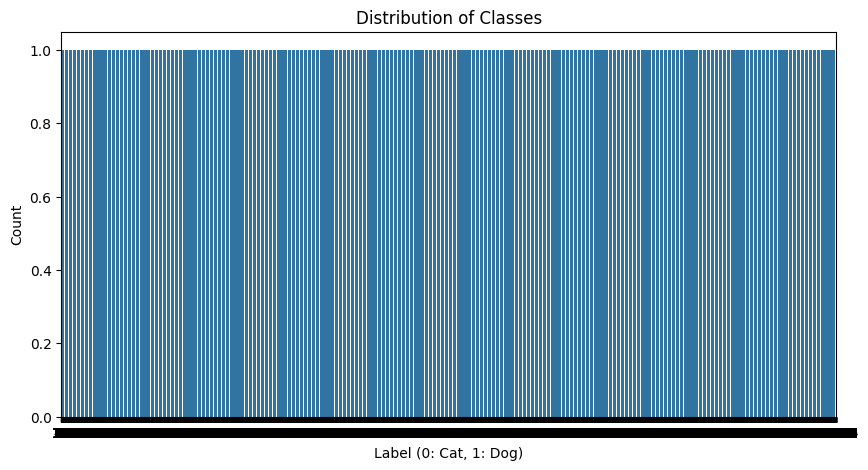

In [ ]:
# Step 1: Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of classes
plt.figure(figsize=(10, 5))
sns.countplot(df['label'])
plt.title('Distribution of Classes')
plt.xlabel('Label (0: Cat, 1: Dog)')
plt.ylabel('Count')
plt.show()


In [ ]:
# Display a grid of images for Dogs
plt.figure(figsize=(25, 25))
temp = df[df['label'] == 1]['images']
start = random.randint(0, len(temp) - 25)
files = temp[start:start + 25]

for index, file in enumerate(files):
    plt.subplot(5, 5, index + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Dog')
    plt.axis('off')




In [ ]:
# Display a grid of images for Cats
plt.figure(figsize=(25, 25))
temp = df[df['label'] == 0]['images']
start = random.randint(0, len(temp) - 25)
files = temp[start:start + 25]

for index, file in enumerate(files):
    plt.subplot(5, 5, index + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Cat')
    plt.axis('off')

In [ ]:
# Step 2: Create Data Generators
from sklearn.model_selection import train_test_split


# Convert labels to string for compatibility
df['label'] = df['label'].astype('str')

# Split the dataset into training and testing sets
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Create ImageDataGenerators
train_generator = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=40,  # Data augmentation
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_generator = ImageDataGenerator(rescale=1./255)

# Create data iterators
train_iterator = train_generator.flow_from_dataframe(
    train,
    x_col='images',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

val_iterator = val_generator.flow_from_dataframe(
    test,
    x_col='images',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)


Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [ ]:
# Step 3: Model Creation
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Build the CNN model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPool2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
 #Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,447,137 (24.59 MB)

 Trainable params: 6,447,137 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 4: Train the Model
history = model.fit(train_iterator, epochs=10, validation_data=val_iterator)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
128/625 ━━━━━━━━━━━━━━━━━━━━ 2:17 276ms/step - accuracy: 0.5345 - loss: 0.7017

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 207s 323ms/step - accuracy: 0.6102 - loss: 0.6507 - val_accuracy: 0.6876 - val_loss: 0.5907
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 182s 292ms/step - accuracy: 0.7146 - loss: 0.5536 - val_accuracy: 0.7586 - val_loss: 0.4867
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 180s 288ms/step - accuracy: 0.7511 - loss: 0.5045 - val_accuracy: 0.7822 - val_loss: 0.4496
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 201s 287ms/step - accuracy: 0.7703 - loss: 0.4726 - val_accuracy: 0.7988 - val_loss: 0.4284
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 185s 296ms/step - accuracy: 0.7961 - loss: 0.4372 - val_accuracy: 0.8128 - val_loss: 0.4073
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 182s 292ms/step - accuracy: 0.7995 - loss: 0.4324 - val_accuracy: 0.8178 - val_loss: 0.3905
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 181s 289ms/step - accuracy: 0.8021 - loss: 0.4161 - val_accuracy: 0.8222 - val_loss: 0.3821
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 180s 288ms/step - accuracy: 0.8190 - loss: 0.39

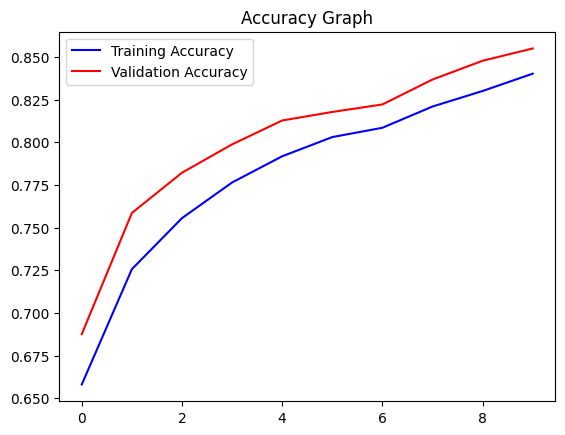

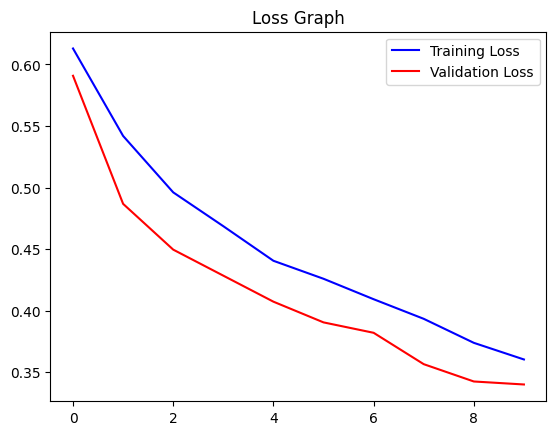

In [ ]:
# Step 5: Visualization of Results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
# Step 9: Test with Real Image
image_path = "/content/cutie.jpg"  # path of the image
img = load_img(image_path, target_size=(128, 128))
img = np.array(img)
img = img / 255.0  # normalize the image
img = img.reshape(1, 128, 128, 3)  # reshape for prediction
pred = model.predict(img)

if pred[0] > 0.5:
    label = 'Dog'
else:
    label = 'Cat'
print(label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Cat


In [ ]:
# Save the model
model.save('dog_vs_cat_model.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'your_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/dog_vs_cat_model.h5')

In [ ]:
!pip install keras-flops


In [ ]:
from keras_flops import get_flops

flops = get_flops(model, batch_size=1)
print(f"FLOPs: {flops:,}")
flops = get_flops(model, batch_size=1)
print(f"FLOPs: {flops:,}")

KeyError: "Registering two statistical functions with name 'FusedBatchNormV3,flops'! (Previous registration was in register /usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/registry.py:65)"

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

model = load_model('/content/dog_vs_cat_model.h5')

# Define a concrete function for the model
@tf.function
def model_fn(x):
    return model(x)

# Create sample input
input_shape = [1] + list(model.input_shape[1:])
inputs = tf.random.normal(input_shape)

# Trace the model
concrete_func = model_fn.get_concrete_function(tf.TensorSpec(shape=input_shape, dtype=tf.float32))

# Profile the FLOPs
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

frozen_func = convert_variables_to_constants_v2(concrete_func)
graph_def = frozen_func.graph.as_graph_def()

# Use TF profiler
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import importer
from tensorflow.python.framework import ops
from tensorflow.python.profiler import model_analyzer
from tensorflow.python.profiler import option_builder

with tf.Graph().as_default() as graph:
    tf.import_graph_def(graph_def, name="")
    with tf.compat.v1.Session(graph=graph) as sess:
        opts = option_builder.ProfileOptionBuilder.float_operation()
        flops = model_analyzer.profile(sess.graph, options=opts)
        print(f"Total FLOPs: {flops.total_float_ops:,}")


Total FLOPs: 90,600,225
